Setup

In [1]:
%matplotlib inline

import dataLoader
import matplotlib.pyplot as plt
import torch
import CNN
import numpy as np

# from config_plots import global_settings
# global_settings()
import warnings
warnings.filterwarnings("ignore")

Hyper parameters

In [2]:
# defining global variables
experimentName = "quicktest4"
useRandomSearch = False
numOfExperiments=2

from configParser import ConfigParser, getModelName
hyperpSearchObject = ConfigParser(experimentName).getHyperpSearchObject()

experimentName = experimentName + "/hyperp-search"
import TrialStatistics
ts = TrialStatistics.TrialStatistics(experimentName)

Cuda support

In [3]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


Define objective function

In [4]:
import os
from torch import nn

all_experiment_params = []
def objective(experiment_params):
    experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1
    
    print("experiment: ", experiment_params)
    all_experiment_params.append(experiment_params)
    
    # load images
    dataset = dataLoader.FishDataset(experiment_params)
    numberOfSpecies = len(dataset.getSpeciesList())

    for i in range(experiment_params["numOfTrials"]):
        trialName = experimentName+"/"+getModelName(experiment_params, i)

        # Train/Load model
        model = CNN.CNN(numberOfSpecies, experiment_params)
        if os.path.exists(CNN.getModelFile(trialName)):
            CNN.loadModel(model, trialName)
            test_loader = dataLoader.loadTestLoader(trialName)
            print("Model {0} loaded!".format(trialName))
        else:
            train_loader, validation_loader, test_loader = dataLoader.getLoadersFromDataset(dataset, 
                                                                                            experiment_params, 
                                                                                            trialName)
            loss_list, accuracy_list, epochs, time_elapsed = CNN.trainModel(train_loader, 
                                                                            validation_loader, 
                                                                            experiment_params, 
                                                                            model, trialName)
        
        # Update trial outcomes for statistics
        predlist, lbllist = CNN.getLoaderPredictions(test_loader, model)
        ts.addTrialPredictions(experiment_params, predlist, lbllist, numberOfSpecies)

        ts.addTrial(experiment_params,
                    {'loss': CNN.getCrossEntropyFromLoader(test_loader, model),
                     'accuracy': CNN.getAccuracyFromLoader(test_loader, model),
                     'time': time_elapsed,
                     'epochs': epochs
                    }, i)
                
    answer ={
        'loss': ts.getStatistic(experiment_params, 'loss', 'mean'),
        'loss-std': ts.getStatistic(experiment_params, 'loss', 'std'),
        'time': ts.getStatistic(experiment_params, 'time', 'mean'),
        'time-std': ts.getStatistic(experiment_params, 'time', 'std'),
        'epochs': ts.getStatistic(experiment_params, 'epochs', 'mean'),
        'epochs-std': ts.getStatistic(experiment_params, 'epochs', 'std'),
        'accuracy': ts.getStatistic(experiment_params, 'accuracy', 'mean'),
        'accuracy-std': ts.getStatistic(experiment_params, 'accuracy', 'std'),
        'status': STATUS_OK,}
    
    return {**experiment_params, **answer}

Iterate

In [5]:
from hyperopt import fmin, hp, STATUS_OK, Trials, space_eval, plotting, rand, tpe
import pickle

trials = Trials()
bestLoss = fmin(objective, 
                        space=hyperpSearchObject, 
                        algo=rand.suggest if useRandomSearch == False else tpe.suggest, 
                        trials=trials,
                        max_evals=numOfExperiments)

experiment:                                        
{'batchSize': 10, 'imageDimension': 28, 'image_path': './Fish_toy/images', 'kernelSize': 9, 'kernels': (9, 27), 'n_channels': 1, 'n_epochs': 3, 'numOfTrials': 3, 'patience': 1, 'training_count': 2, 'useZCAWhitening': False, 'validation_count': 1}
Training started...                                
  0%|          | 0/2 [00:11<?, ?it/s, best loss: ?]

100% (3 of 3) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06


Early stopping
total number of epochs:  2


N/A% (0 of 3) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (3 of 3) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 3) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (3 of 3) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07


Early stopping
total number of epochs:  2
['batchSize', 'imageDimension', 'image_path', 'kernelSize', 'kernels', 'n_channels', 'n_epochs', 'numOfTrials', 'patience', 'training_count', 'useZCAWhitening', 'validation_count', 'hash']
 50%|█████     | 1/2 [00:56<00:56, 56.39s/it, best loss: 3.2103183269500732]experiment:  {'batchSize': 10, 'imageDimension': 28, 'image_path': './Fish_toy/images', 'kernelSize': 9, 'kernels': (14, 20), 'n_channels': 1, 'n_epochs': 3, 'numOfTrials': 3, 'patience': 2, 'training_count': 2, 'useZCAWhitening': False, 'validation_count': 1}


N/A% (0 of 3) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (3 of 3) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 3) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (3 of 3) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 3) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (3 of 3) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07


['batchSize', 'imageDimension', 'image_path', 'kernelSize', 'kernels', 'n_channels', 'n_epochs', 'numOfTrials', 'patience', 'training_count', 'useZCAWhitening', 'validation_count', 'hash']
100%|██████████| 2/2 [02:06<00:00, 60.37s/it, best loss: 3.2102184295654297]


Analyze

In [6]:
ts.showStatistics()
ts.showStatistics(False)

import pandas as pd
from IPython.display import display, HTML

# bestParams = space_eval(hyperpSearchObject, bestLoss)
# print("best params = ", pd.DataFrame(bestParams, index=[0]))
best_trial = sorted(trials.results, key=lambda x: x['loss'], reverse=False)[0]
best_trial['kernels'] = str(' '.join([str(elem) for elem in best_trial['kernels']]))
print("Best trial")
display(HTML(pd.DataFrame(best_trial, index=[0]).to_html()))

# save trials
pickle.dump(trials, open(experimentName+"/trials.p", "wb"))
ts.saveStatistics()
ts.saveStatistics(False)

Aggregated statistics


Raw statistics


,batchSize,imageDimension,image_path,kernelSize,kernels,n_channels,n_epochs,numOfTrials,patience,training_count,useZCAWhitening,validation_count,loss,accuracy,time,epochs,hash,trial
0,10,28,./Fish_toy/images,9,9 27,1,3,3,1,2,False,1,3.214801,0.142857,6.298377,3,-7275060819192677185,0
1,10,28,./Fish_toy/images,9,9 27,1,3,3,1,2,False,1,3.210054,0.095238,7.733036,3,-7275060819192677185,1
2,10,28,./Fish_toy/images,9,9 27,1,3,3,1,2,False,1,3.206100,0.095238,7.261037,3,-7275060819192677185,2
3,10,28,./Fish_toy/images,9,14 20,1,3,3,2,2,False,1,3.214808,0.047619,6.428955,3,-4224969870319303423,0
4,10,28,./Fish_toy/images,9,14 20,1,3,3,2,2,False,1,3.212413,0.071429,6.347252,3,-4224969870319303423,1
5,10,28,./Fish_toy/images,9,14 20,1,3,3,2,2,False,1,3.203434,0.047619,6.898059,3,-4224969870319303423,2


Best trial


,batchSize,imageDimension,image_path,kernelSize,kernels,n_channels,n_epochs,numOfTrials,patience,training_count,useZCAWhitening,validation_count,loss,loss-std,time,time-std,epochs,epochs-std,accuracy,accuracy-std,status
0,10,28,./Fish_toy/images,9,14 20,1,3,3,2,2,False,1,3.210218,0.005996,6.558088,0.297243,3,0.0,0.055556,0.013746,ok


Generate confusion matrices

experiment:  {'batchSize': 10, 'imageDimension': 28, 'image_path': './Fish_toy/images', 'kernelSize': 9, 'kernels': (9, 27), 'n_channels': 1, 'n_epochs': 3, 'numOfTrials': 3, 'patience': 1, 'training_count': 2, 'useZCAWhitening': False, 'validation_count': 1}


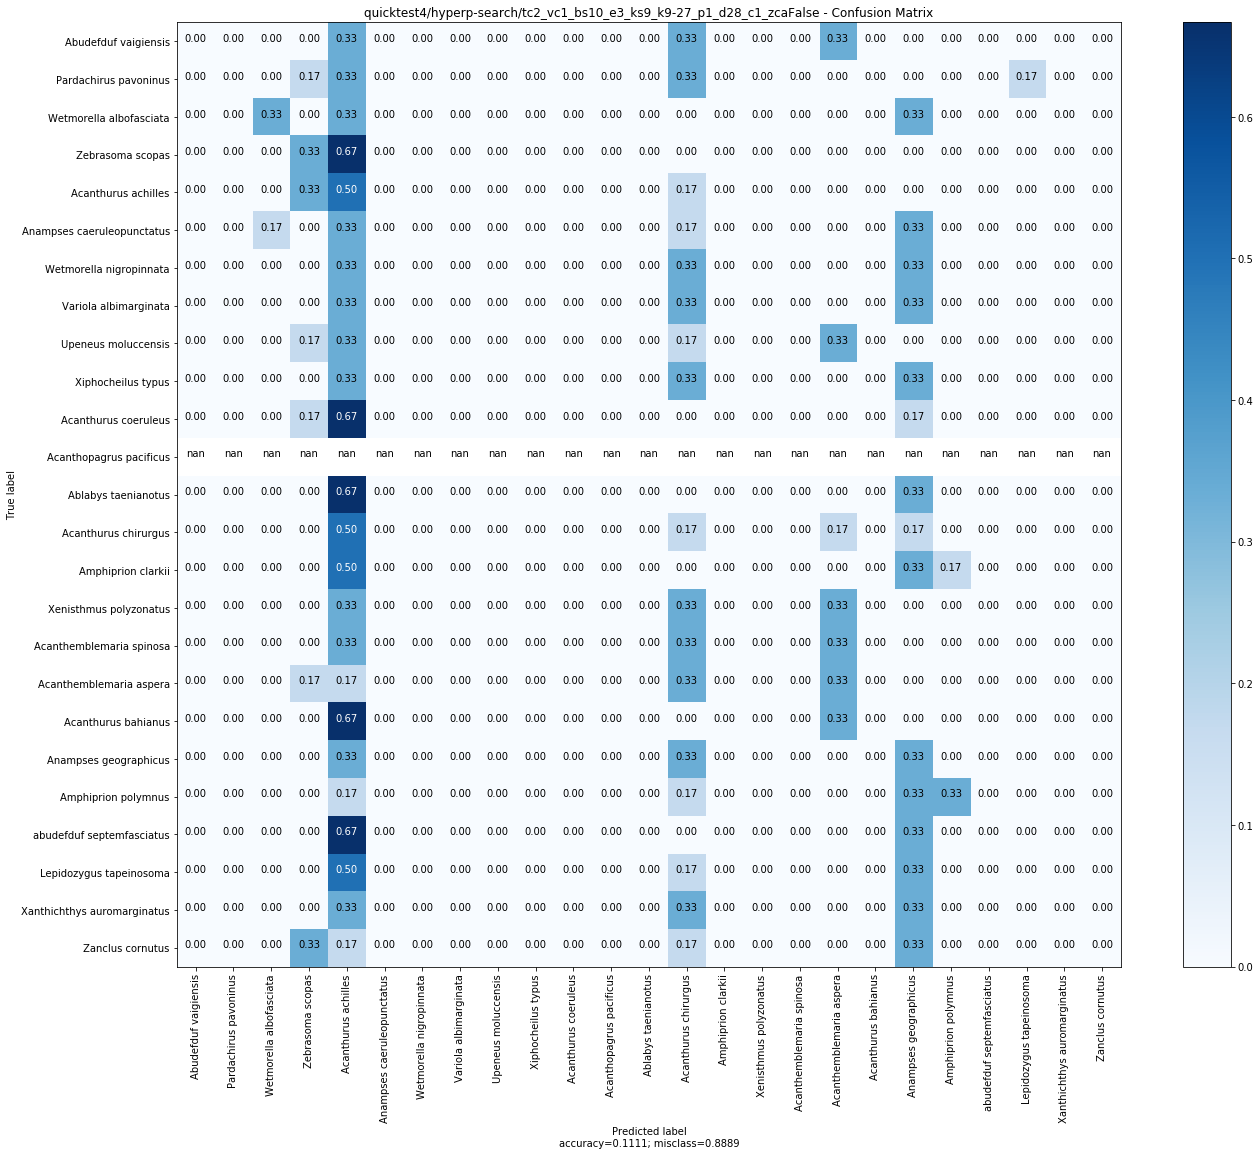

experiment:  {'batchSize': 10, 'imageDimension': 28, 'image_path': './Fish_toy/images', 'kernelSize': 9, 'kernels': (14, 20), 'n_channels': 1, 'n_epochs': 3, 'numOfTrials': 3, 'patience': 2, 'training_count': 2, 'useZCAWhitening': False, 'validation_count': 1}


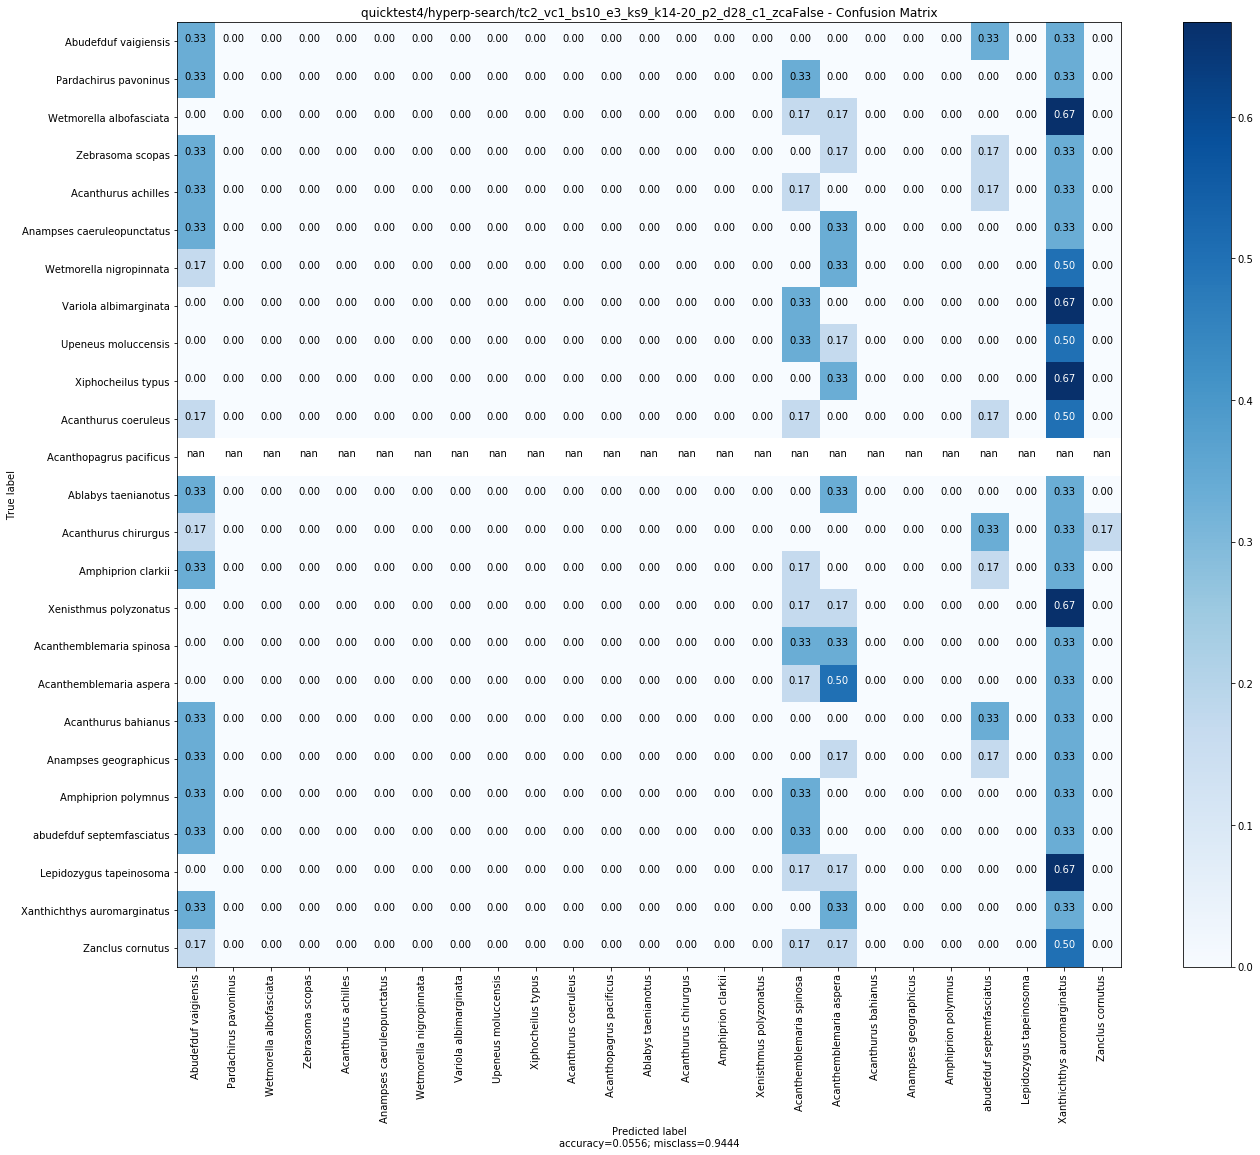

In [7]:
for experiment_params in all_experiment_params:    
    print("experiment: ", experiment_params)
    
    dataset = dataLoader.FishDataset(experiment_params, False)
    speciesList = dataset.getSpeciesList()
    ts.printTrialConfusionMatrix(experiment_params, speciesList, True)